In [324]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [325]:
DATASET_PATH = './data/comandos/'

data_dir = pathlib.Path(DATASET_PATH)

In [326]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['cero' 'cruz' 'no' 'ruido' 'si']


In [327]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 375 files belonging to 5 classes.
Using 300 files for training.
Using 75 files for validation.

label names: ['cero' 'cruz' 'no' 'ruido' 'si']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [328]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [329]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [330]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [331]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [332]:
label_names[[1,1,3,0]]

array(['cruz', 'cruz', 'ruido', 'cero'], dtype='<U5')

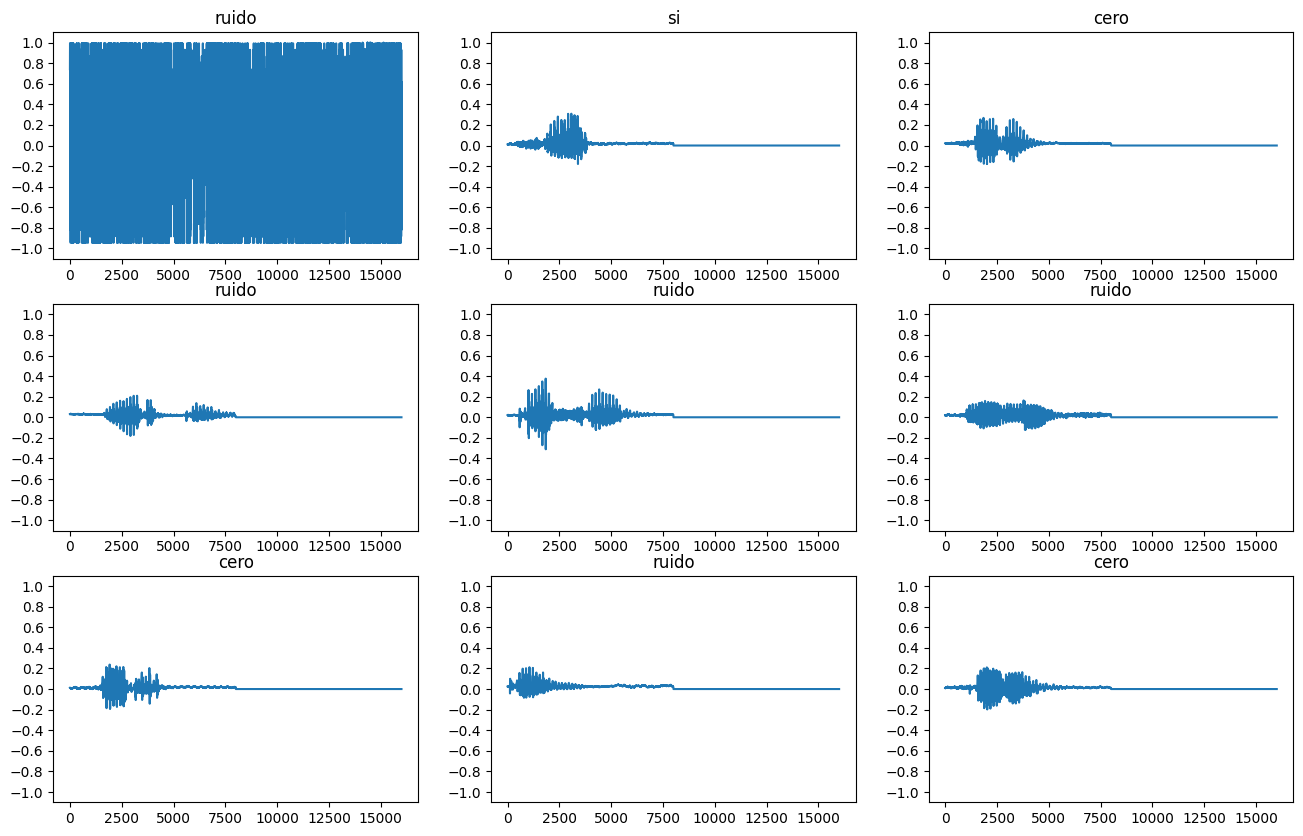

In [333]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [334]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [335]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ruido
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: si
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: cero
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [336]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

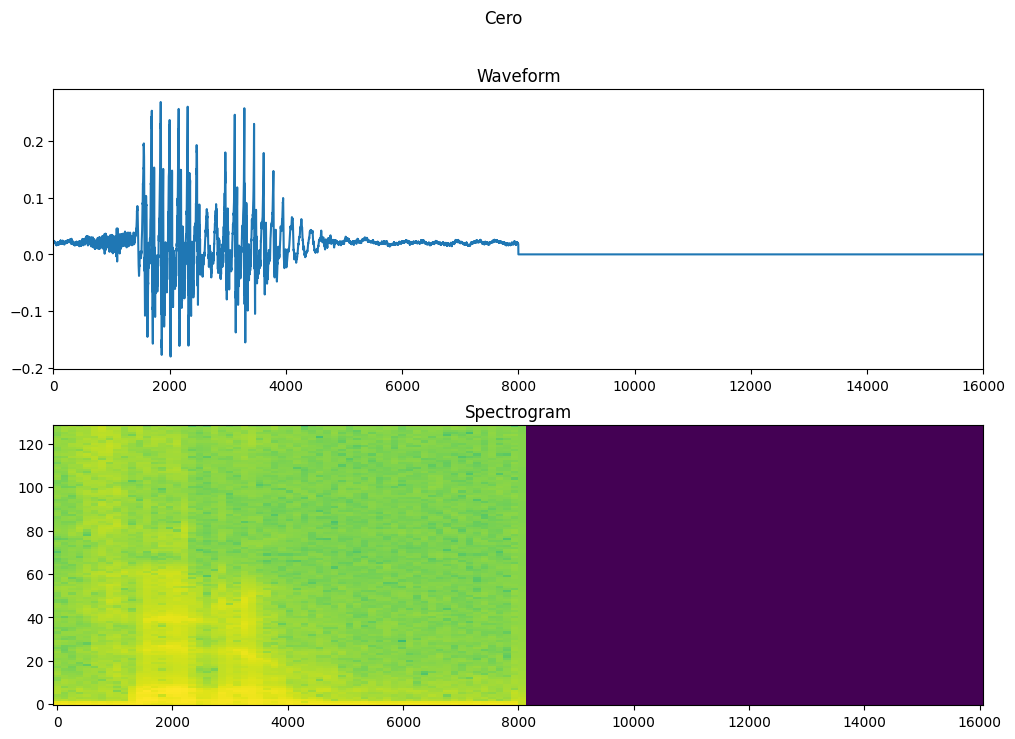

In [337]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [338]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [339]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [340]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

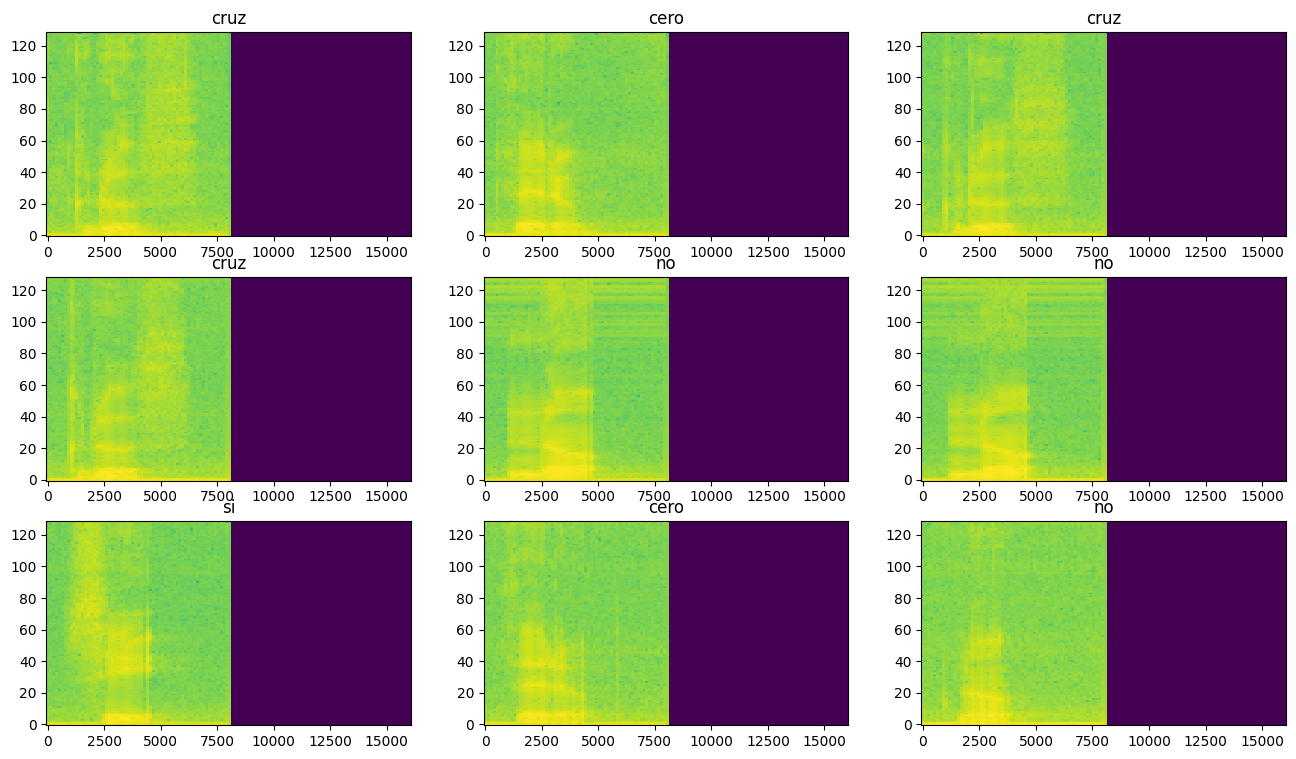

In [341]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [342]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [343]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_39 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_39 (Normaliz  (None, 32, 32, 1)         3         
 ation)                                                          
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 15, 15, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_37 (Flatten)        (None, 3600)              0         
                                                                 
 dense_85 (Dense)         

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [344]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [345]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


5/5 [==============================] - 1s 102ms/step - loss: 1.5393 - accuracy: 0.2667 - val_loss: 1.6339 - val_accuracy: 0.1818
Epoch 2/10
5/5 [==============================] - 0s 21ms/step - loss: 1.4498 - accuracy: 0.3800 - val_loss: 1.4886 - val_accuracy: 0.4545
Epoch 3/10
5/5 [==============================] - 0s 16ms/step - loss: 1.3944 - accuracy: 0.5233 - val_loss: 1.3514 - val_accuracy: 0.4545
Epoch 4/10
5/5 [==============================] - 0s 15ms/step - loss: 1.3204 - accuracy: 0.7133 - val_loss: 1.2738 - val_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 0s 17ms/step - loss: 1.2497 - accuracy: 0.7600 - val_loss: 1.1974 - val_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 1.1771 - accuracy: 0.8000 - val_loss: 1.0935 - val_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 0s 17ms/step - loss: 1.0993 - accuracy: 0.7833 - val_loss: 0.9872 - val_accuracy: 0.8182
Epoch 8/10
5/5 [=====================

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

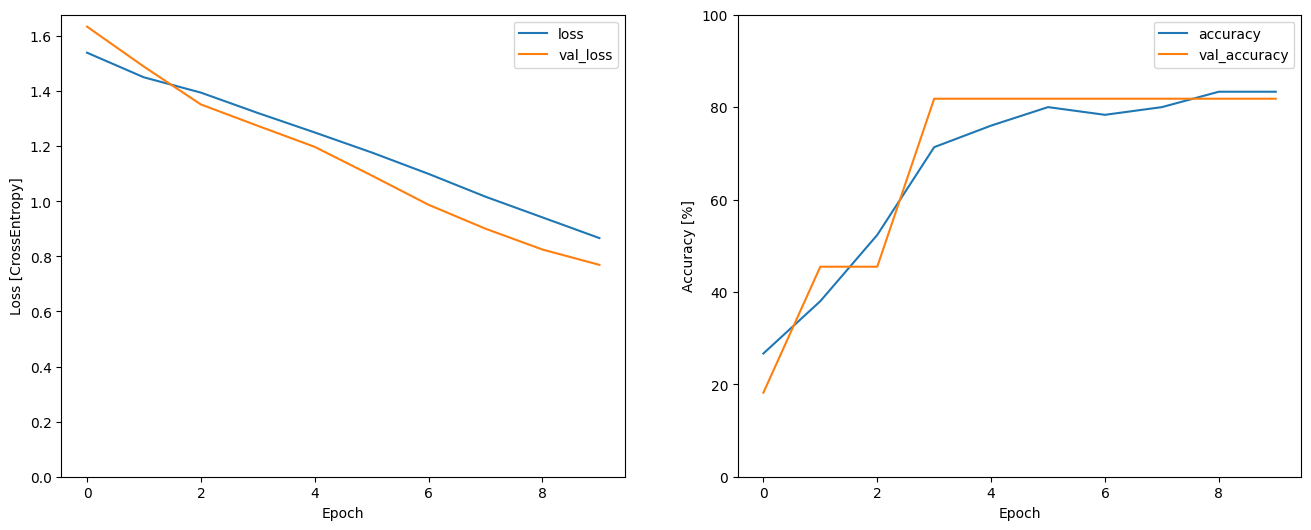

In [346]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [347]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 211ms/step - loss: 0.7709 - accuracy: 0.8906


{'loss': 0.7708746194839478, 'accuracy': 0.890625}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [348]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 0s 120ms/step


In [349]:
y_pred = tf.argmax(y_pred, axis=1)

In [350]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

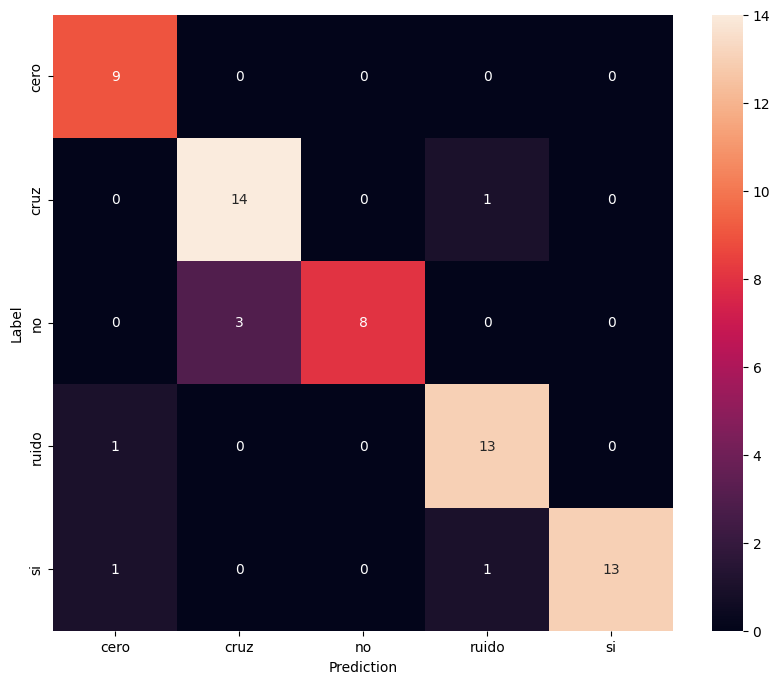

In [351]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

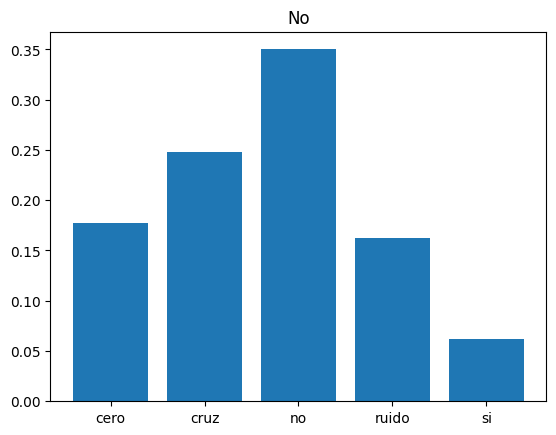

In [352]:
x = data_dir/'no/No_007.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [353]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [354]:
export = ExportModel(model)

Save and reload the model, the reloaded model gives identical output:

In [355]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.19157274,  0.14308092,  0.4873752 , -0.28218532, -1.2436563 ]],
       dtype=float32)>}

In [356]:
# Crear un generador representativo
def representative_dataset_generator():
    for audio, label in train_spectrogram_ds.take(100):  # Ajusta el tamaño según sea necesario
        yield [audio]

# Crear el convertidor de TensorFlow Lite desde el modelo Keras
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Configurar la cuantización
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]  # Configurar para enteros de 8 bits
converter.representative_dataset = representative_dataset_generator

# Configurar cuantización de entrada y salida
converter.inference_input_type = tf.float32  # Tipo de datos de entrada de la cuantización
converter.inference_output_type = tf.float32  # Tipo de datos de salida de la cuantización

# Convertir el modelo a TensorFlow Lite
tflite_model = converter.convert()

# Guardar el modelo TFLite
with open('modelo_rec_reducido.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\34699\AppData\Local\Temp\tmpfs80c_3n\assets


INFO:tensorflow:Assets written to: C:\Users\34699\AppData\Local\Temp\tmpfs80c_3n\assets
c:\Users\34699\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [357]:
interpreter = tf.lite.Interpreter(model_path='./modelo_rec_reducido.tflite')
interpreter.allocate_tensors()
input_tensor_index = interpreter.get_input_details()[0]['index']
output_tensor_index = interpreter.get_output_details()[0]['index']

y_true = []  # Lista para almacenar las etiquetas reales
y_pred = []  # Lista para almacenar las predicciones

# Imprimir las dimensiones esperadas del tensor de entrada y salida
input_shape = interpreter.get_input_details()[0]['shape']
output_shape = interpreter.get_output_details()[0]['shape']


for data, labels in test_spectrogram_ds:  # Iterar sobre el conjunto de datos de prueba
    # Iterar sobre cada muestra en el lote
    for i in range(data.shape[0]):
        # Seleccionar la muestra i del lote
        sample_data = data[i:i+1]  # Asegura que el tamaño del lote sea 1

        interpreter.set_tensor(input_tensor_index, sample_data)
        interpreter.invoke()
        output_tensor = interpreter.get_tensor(output_tensor_index)

        # Asumiendo que output_tensor tiene la forma (1, num_classes)
        predicted_classes = np.argmax(output_tensor, axis=1)

        y_true.append(labels.numpy()[i])
        y_pred.append(predicted_classes[0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcular la precisión
accuracy = np.mean(y_true == y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 87.50%
